In [20]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython import embed
from torchvision.transforms import ToTensor, Compose, CenterCrop, Pad, Resize
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

In [2]:
path_to_dataset="/Users/victoriabarenne/ai4good/dataset/"
path_to_refores= "/Users/victoriabarenne/ai4good/reforesTree/"

In [3]:
final_df= pd.read_csv(path_to_refores+"mapping/final_dataset.csv")

In [4]:
final_df.head()


,img_path,xmin,ymin,xmax,ymax,score,img_name,tile_index,tile_xmin,tile_ymin,...,is_musacea_g,site,X_g,Y_g,updated diameter,group,updated height,AGB,carbon,id
0,Carlos Vera Guevara RGB_3_0_8305_4000_12305.png,3332.557861,19.092411,3661.390137,364.616425,0.531211,Carlos Vera Guevara RGB,3,0,8305,...,1.0,Carlos Vera Guevara RGB,5298.555843,7709.844671,10.281385,banana,0.0,4.293300,1.674387,30
1,Carlos Vera Guevara RGB_3_0_8305_4000_12305.png,3162.579834,2148.233398,3431.632324,2379.467041,0.511510,Carlos Vera Guevara RGB,3,0,8305,...,1.0,Carlos Vera Guevara RGB,5315.345160,8606.745732,13.528139,banana,0.0,7.702971,3.004159,112
2,Carlos Vera Guevara RGB_3_0_8305_4000_12305.png,2893.605713,244.011108,3095.620605,451.257812,0.251310,Carlos Vera Guevara RGB,3,0,8305,...,1.0,Carlos Vera Guevara RGB,5228.142461,7935.770200,12.732366,banana,0.0,6.769828,2.640233,179
3,Carlos Vera Guevara RGB_3_0_8305_4000_12305.png,2595.111084,1703.712402,2765.227295,1865.253418,0.217742,Carlos Vera Guevara RGB,3,0,8305,...,1.0,Carlos Vera Guevara RGB,4434.058601,8354.081799,9.867583,banana,0.0,3.933601,1.534104,93
4,Carlos Vera Guevara RGB_10_7600_7600_11600_116...,249.691879,123.626862,439.557648,302.768402,0.282849,Carlos Vera Guevara RGB,10,7600,7600,...,1.0,Carlos Vera Guevara RGB,8257.952942,7554.538338,17.825312,banana,0.0,13.862143,5.406236,162


In [5]:
my_df=  final_df[['img_name', 'Xmin', 'Ymin', 'Xmax', 'Ymax', 'carbon', 'X_d', 'Y_d', 'X_g', 'Y_g']]
my_df.head()

,img_name,Xmin,Ymin,Xmax,Ymax,carbon,X_d,Y_d,X_g,Y_g
0,Carlos Vera Guevara RGB,3332.557861,8324.092411,3661.390137,8669.616425,1.674387,3496.973999,8496.854418,5298.555843,7709.844671
1,Carlos Vera Guevara RGB,3162.579834,10453.233398,3431.632324,10684.467041,3.004159,3297.106079,10568.850220,5315.345160,8606.745732
2,Carlos Vera Guevara RGB,2893.605713,8549.011108,3095.620605,8756.257812,2.640233,2994.613159,8652.634460,5228.142461,7935.770200
3,Carlos Vera Guevara RGB,2595.111084,10008.712402,2765.227295,10170.253418,1.534104,2680.169189,10089.482910,4434.058601,8354.081799
4,Carlos Vera Guevara RGB,7849.691879,7723.626862,8039.557648,7902.768402,5.406236,7944.624763,7813.197632,8257.952942,7554.538338


In [6]:
print(np.all((my_df['Xmin']<= my_df['X_d'])&(my_df['X_d']<=my_df['Xmax'])))
print(np.all((my_df['Ymin']<= my_df['Y_d'])&(my_df['Y_d']<=my_df['Ymax'])))
print(np.max((my_df['Xmax']-my_df['Xmin'])/2 +my_df['Xmin']- my_df['X_d']))
# X_d, Y_d are the center coordinates of the bounding boxes

True
True
3.637978807091713e-12


In [7]:
sites= np.unique(final_df["img_name"])
print(sites)

['Carlos Vera Arteaga RGB' 'Carlos Vera Guevara RGB' 'Flora Pluas RGB'
 'Leonor Aspiazu RGB' 'Manuel Macias RGB' 'Nestor Macias RGB']


In [24]:
tree_crowns = pd.DataFrame([] ,columns=["tree_img", "coord", "x_center", "y_center",
                                        "x_field", "y_field", "site", "carbon"])

for site in sites:
    print(site)
    df_site= my_df[my_df['img_name']==site]
    df_site= df_site.reset_index()
    print(len(df_site))
    image_site= cv2.imread(f"/Users/victoriabarenne/ai4good/dataset/sites/{site}_unpadded_image.png")
    print(image_site.shape, type(image_site))
    for i in range(len(df_site)):
        tree_coord= np.array(df_site.iloc[i][['Xmin', 'Ymin', 'Xmax', 'Ymax']]).astype(int)
        carbon= df_site.iloc[i]['carbon'].item()
        tree_img= image_site[tree_coord[1]:tree_coord[3], tree_coord[0]:tree_coord[2], :]
        x_center= df_site.iloc[i]['X_d'].item()
        y_center= df_site.iloc[i]['Y_d'].item()
        x_field= df_site.iloc[i]['X_g'].item()
        y_field= df_site.iloc[i]['Y_g'].item()

        new_df=pd.DataFrame([[tree_img, tree_coord, x_center, y_center, x_field, y_field, site, carbon]],
                            columns=tree_crowns.columns)
        tree_crowns=pd.concat([tree_crowns, new_df], ignore_index=True)


Carlos Vera Arteaga RGB
   index                 img_name         Xmin         Ymin         Xmax  \
0    182  Carlos Vera Arteaga RGB  1222.391357  7187.081299  1601.264648   
1    183  Carlos Vera Arteaga RGB   188.087189  6759.900879   514.519958   
2    184  Carlos Vera Arteaga RGB  2431.368164  5242.750732  2616.983398   
3    185  Carlos Vera Arteaga RGB   883.838440  4996.413208  1077.341797   
4    186  Carlos Vera Arteaga RGB  3858.925537  4824.890381  3993.801025   

          Ymax    carbon          X_d          Y_d          X_g          Y_g  
0  7602.532959  4.807974  1411.828003  7394.807129  4640.349834  8112.414705  
1  7136.374756  0.812334   351.303574  6948.137817  3980.259000  8194.854491  
2  5438.224731  1.440791  2524.175781  5340.487732  5405.844179  6443.009026  
3  5197.156250  4.246788   980.590118  5096.784729  4563.800399  6716.619993  
4  5092.155396  1.926678  3926.363281  4958.522888  6374.178376  5968.423227  
743
(15053, 15297, 3) <class 'numpy.ndarray'>

In [25]:
print(tree_crowns["tree_img"][0].shape)

(415, 379, 3)


In [26]:
tree_crowns.head()

,tree_img,coord,x_center,y_center,x_field,y_field,site,carbon
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[1222, 7187, 1601, 7602]",1411.828003,7394.807129,4640.349834,8112.414705,Carlos Vera Arteaga RGB,4.807974
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[188, 6759, 514, 7136]",351.303574,6948.137817,3980.259000,8194.854491,Carlos Vera Arteaga RGB,0.812334
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[2431, 5242, 2616, 5438]",2524.175781,5340.487732,5405.844179,6443.009026,Carlos Vera Arteaga RGB,1.440791
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[883, 4996, 1077, 5197]",980.590118,5096.784729,4563.800399,6716.619993,Carlos Vera Arteaga RGB,4.246788
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[3858, 4824, 3993, 5092]",3926.363281,4958.522888,6374.178376,5968.423227,Carlos Vera Arteaga RGB,1.926678


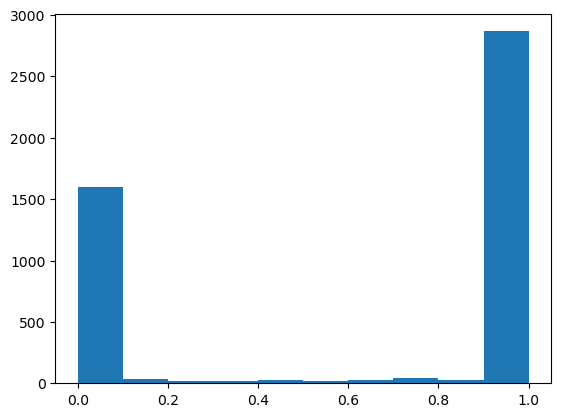

In [27]:
white_percentage= np.zeros(len(tree_crowns))
for i in range(len(tree_crowns)):
    tree_img= tree_crowns.iloc[i]["tree_img"]
    surface= tree_img.shape[0]*tree_img.shape[1]
    if surface>0:
        white_percentage[i]= np.sum(np.all(tree_img==0, axis=2))/surface
    elif surface==0:
        white_percentage[i]=1
plt.hist(white_percentage)
plt.show()

In [28]:
white_threshold= 0.8
tree_crowns_filtered= tree_crowns.iloc[white_percentage<white_threshold]
tree_crowns_filtered= tree_crowns_filtered.reset_index(drop=True)
print(f"Only {len(tree_crowns_filtered)}/{len(tree_crowns)} of the bounding boxes were inside the site boundaries")

Only 1770/4663 of the bounding boxes were inside the site boundaries


In [29]:
for site in sites:
    tree_crowns_site=tree_crowns[tree_crowns["site"]==site]
    tree_crowns_filtered_site=tree_crowns_filtered[tree_crowns_filtered["site"]==site]
    print(f"{site}: {len(tree_crowns_filtered_site)}/{len(tree_crowns_site)} of the bounding boxes were inside the site boundaries")

Carlos Vera Arteaga RGB: 222/743 of the bounding boxes were inside the site boundaries
Carlos Vera Guevara RGB: 421/929 of the bounding boxes were inside the site boundaries
Flora Pluas RGB: 237/846 of the bounding boxes were inside the site boundaries
Leonor Aspiazu RGB: 341/789 of the bounding boxes were inside the site boundaries
Manuel Macias RGB: 178/484 of the bounding boxes were inside the site boundaries
Nestor Macias RGB: 371/872 of the bounding boxes were inside the site boundaries


In [30]:
tree_crowns_filtered.head()


,tree_img,coord,x_center,y_center,x_field,y_field,site,carbon
0,"[[[60, 69, 89], [88, 99, 119], [101, 120, 138]...","[9059, 4969, 9286, 5211]",9172.827087,5090.268555,9431.849179,4538.204334,Carlos Vera Arteaga RGB,2.236270
1,"[[[105, 107, 105], [79, 85, 82], [77, 82, 79],...","[8174, 7122, 8411, 7369]",8293.343384,7246.081177,7641.281463,6659.134953,Carlos Vera Arteaga RGB,3.555729
2,"[[[159, 235, 208], [158, 246, 216], [134, 230,...","[11281, 4453, 11527, 4697]",11404.387573,4575.408203,10311.144863,3778.087220,Carlos Vera Arteaga RGB,1.430615
3,"[[[172, 170, 172], [181, 179, 181], [129, 127,...","[8648, 5079, 8886, 5331]",8767.547729,5205.439087,9263.569620,4243.203584,Carlos Vera Arteaga RGB,3.234511
4,"[[[209, 207, 211], [225, 221, 222], [208, 206,...","[10353, 6624, 10545, 6801]",10449.686157,6713.099365,9621.230973,4592.904247,Carlos Vera Arteaga RGB,1.986641


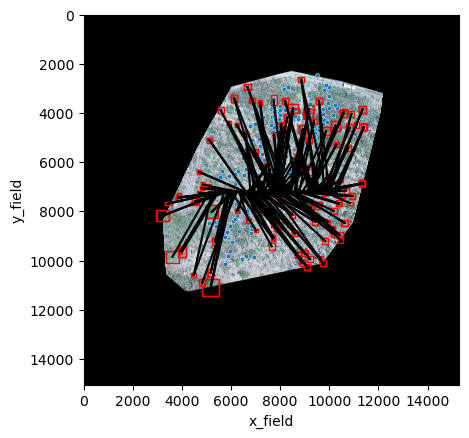

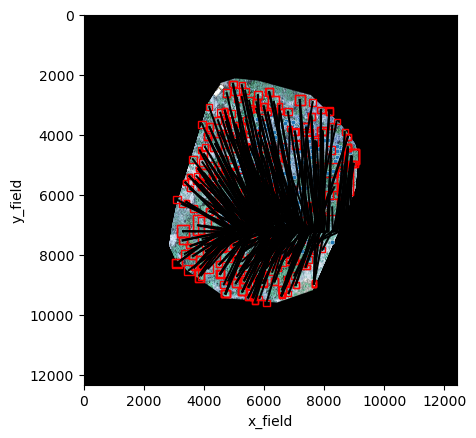

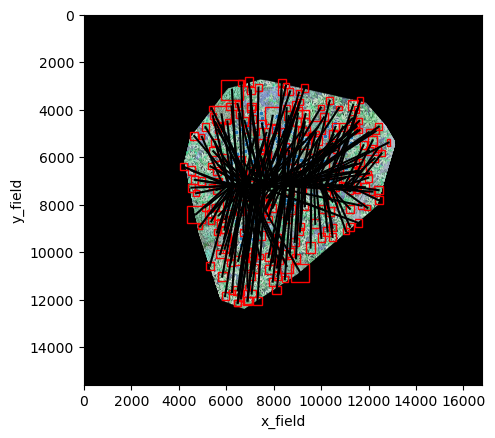

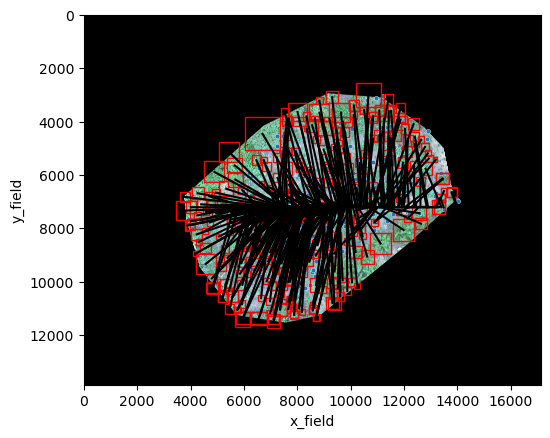

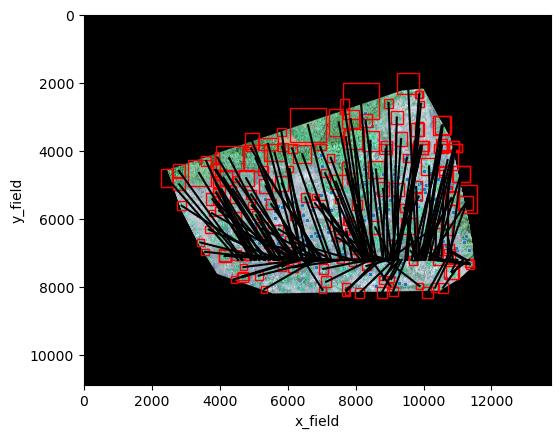

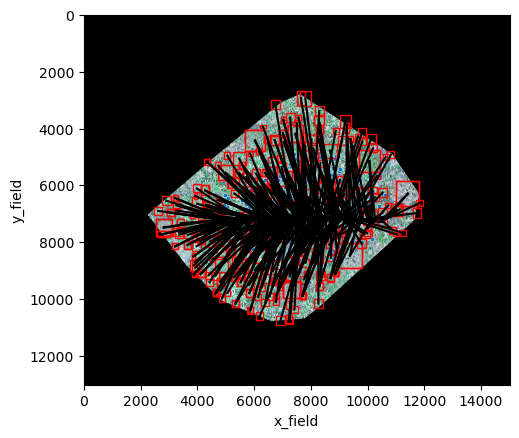

In [44]:
for site in sites:
    image_site= cv2.imread(f"/Users/victoriabarenne/ai4good/dataset/sites/{site}_unpadded_image.png")
    df_site= tree_crowns_filtered[tree_crowns_filtered["site"]==site]

    ax = plt.gca()
    plt.imshow(image_site)
    sns.scatterplot(data=df_site, x="x_field", y="y_field", s=10)

    for i in range(len(df_site)):
        box = df_site.iloc[i]["coord"]
        tree_rec = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1,
                                 edgecolor='r', facecolor='none')

        x_center= df_site.iloc[i]["x_center"]
        y_center= df_site.iloc[i]["y_center"]
        x_field= df_site.iloc[i]["x_field"]
        y_filed= df_site.iloc[i]["y_field"]

        plt.plot([x_center,x_field],[y_center,y_field], color="black")
        ax.add_patch(tree_rec)


    plt.show()

In [184]:
transform= Compose([ToTensor(), CenterCrop(800)])
tree_crowns_final=pd.DataFrame([], columns=["tree_img", "site", "carbon"])

for i in range(len(tree_crowns_filtered)):
    tree_img= tree_crowns_filtered.iloc[i]["tree_img"]
    transformed_img= transform(tree_img)
    site = tree_crowns_filtered["site"][i]
    carbon= tree_crowns_filtered["carbon"][i]

    new_df=pd.DataFrame([[transformed_img, site, carbon]], columns=tree_crowns_final.columns)
    tree_crowns_final=pd.concat([tree_crowns_final, new_df], ignore_index=True)

print(len(tree_crowns_final), len(tree_crowns_filtered))



1529 1529


In [185]:
print(tree_crowns_final["tree_img"][0].shape)
tree_crowns_final.head()

torch.Size([3, 800, 800])


,tree_img,site,carbon
0,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(...",Carlos Vera Arteaga RGB,1.674387
1,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(...",Carlos Vera Arteaga RGB,3.004159
2,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(...",Carlos Vera Arteaga RGB,5.406236
3,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(...",Carlos Vera Arteaga RGB,3.079940
4,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(...",Carlos Vera Arteaga RGB,5.825807


In [189]:
train, val, test= create_split_dataframe("", tree_crowns_filtered, [4,1,1])
print(len(train), len(val), len(test))


1017 268 244


In [191]:
class TreeCrown(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform= transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, item):
        """
        Loading samples based on the information contained
        in self.df.
        """
        site = self.df["site"][item]
        image = self.df["tree_img"][item]
        carbon = self.df["carbon"][item]


        if self.transform is not None:
            image = self.transform(image)

        return image, carbon, site


In [192]:
def train_val_test_dataset(data:pd.DataFrame, splits, transform):
    train, val, test= create_split_dataframe("", data, splits)
    train_dataset= TreeCrown(train, transform)
    val_dataset = TreeCrown(val, transform)
    test_dataset = TreeCrown(test, transform)

    return train_dataset, val_dataset, test_dataset

def train_val_test_dataloader(data: pd.DataFrame, splits, batch_size, transform=None):
    train_dataset, val_dataset, test_dataset= train_val_test_dataset( data, splits, transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader


In [204]:
train_loader, val_loader, test_loader= train_val_test_dataloader(tree_crowns_final, splits=[4,1,1], batch_size=32, transform=Resize(224))

In [214]:
tree_img_sampled, carbon_sample, site_sample= next(iter(train_loader))
print(tree_img_sampled.shape, carbon_sample.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])
